
🚀 Training Random Forest model...
✅ Model training complete!


Device set to use cpu



🔍 Manual Testing Results:
+----+----------------------+----------------------+----------------------------+
|    | text                 |   RF_Predicted Label | BERT_Predicted Sentiment   |
+====+======================+======================+============================+
|  0 | 21st century wire    |                    0 | 2 stars                    |
|    | says this week the   |                      |                            |
|    | historic             |                      |                            |
|    | international        |                      |                            |
|    | iranian nuclear deal |                      |                            |
|    | was punctuated by a  |                      |                            |
|    | twoway prisoner swap |                      |                            |
|    | between washington   |                      |                            |
|    | and tehran but it    |                      |                   

<ipython-input-3-5b6099acdbb3>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary.values, palette='viridis')


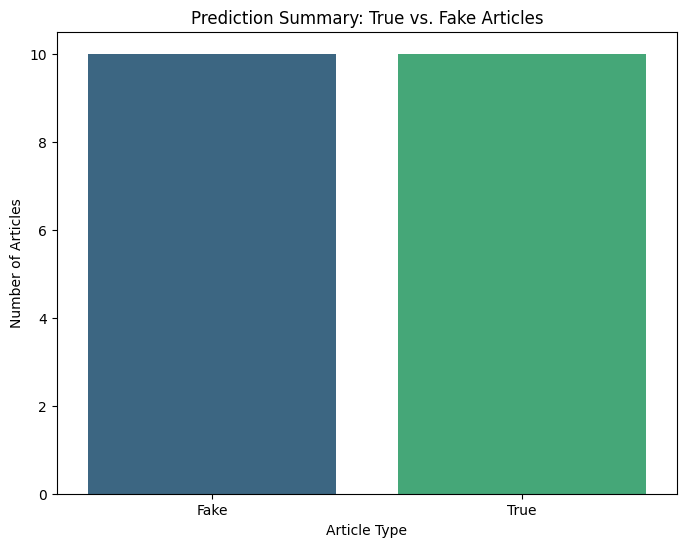

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from textblob import TextBlob
from transformers import pipeline, AutoTokenizer
from tabulate import tabulate

# Advanced Text Preprocessing Function
def preprocess_text(df, column):
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r'[^\w\s]', '', regex=True)
    df['text_length'] = df[column].str.len()
    df['sentiment'] = df[column].apply(lambda x: TextBlob(x).sentiment.polarity)
    return df

# Load Datasets
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')
manual_testing_data = pd.read_csv('manual_testing.csv')

# Add Labels
true_data['label'] = 1
fake_data['label'] = 0

# Combine Datasets
data = pd.concat([true_data, fake_data], axis=0).reset_index(drop=True)

# Preprocess Text Data
data = preprocess_text(data, 'text')
manual_testing_data = preprocess_text(manual_testing_data, 'text')

# Text Representation using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(data['text'])
y_train = data['label']

# Train Random Forest Model
print("\n🚀 Training Random Forest model...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
print("✅ Model training complete!")

# Load Pre-trained BERT Model
bert_classifier = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")
bert_tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Truncate Text for BERT Compatibility
def truncate_text(text, max_length=512):
    tokens = bert_tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        add_special_tokens=True
    )
    return bert_tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)

manual_testing_data['truncated_text'] = manual_testing_data['text'].apply(lambda x: truncate_text(x, max_length=512))

# Manual Testing with Random Forest
manual_tfidf = tfidf.transform(manual_testing_data['text'])
manual_rf_predictions = rf_model.predict(manual_tfidf)

# Add Predictions to Manual Testing Data
manual_testing_data['RF_Predicted Label'] = manual_rf_predictions
manual_testing_data['BERT_Predicted Sentiment'] = manual_testing_data['truncated_text'].apply(
    lambda x: bert_classifier(x)[0]['label']
)

# Display Results in Tabular Format
print("\n🔍 Manual Testing Results:")
print(tabulate(
    manual_testing_data[['text', 'RF_Predicted Label', 'BERT_Predicted Sentiment']],
    headers='keys',
    tablefmt='grid',
    maxcolwidths=[50, 20, 20]
))

# Evaluation on Manual Testing Data (if Ground Truth is Available)
if 'label' in manual_testing_data.columns:
    y_manual_test = manual_testing_data['label']
    accuracy = accuracy_score(y_manual_test, manual_rf_predictions)
    print(f"\n✨ Evaluation Results:\nAccuracy: {accuracy:.2%}")
    print("\n🔔 Classification Report:")
    print(classification_report(y_manual_test, manual_rf_predictions, target_names=['Fake', 'True']))

    # AUC-ROC Curve
    rf_probs = rf_model.predict_proba(manual_tfidf)[:, 1]
    roc_auc = roc_auc_score(y_manual_test, rf_probs)
    print(f"AUC-ROC: {roc_auc:.2f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_manual_test, manual_rf_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Visualizing Prediction Summary
summary = manual_testing_data['RF_Predicted Label'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=summary.index, y=summary.values, palette='viridis')
plt.title('Prediction Summary: True vs. Fake Articles')
plt.xlabel('Article Type')
plt.ylabel('Number of Articles')
plt.xticks([0, 1], ['Fake', 'True'])
plt.show()
